## Capstone: Further EDA, Feature Engineering & Pre Processing 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

#### Introduction

Within this sheet I will perform further EDA, feature engineering, pre-processing and some baseline models in advance of more robust modelling. 

Considerations: 
- Encoding: 
    - Which variables to encode and how, the baseline will be one-hot encoding for initial models
- Feature Engineering: 
    - Features with low variance: Based on encoding remove features with low variance
    - Features with low fscores in relation to the target to remove dimensionality 
    - PCA is not being considered at this stage due to the necessity to understand the drivers of market value
    - Consideration for how position impacts import features & baseline models - Should we use position specific models rather than one model for all? 
    - Target Variable: Should the distribution be transformed by taking the logarithm? 
- Baseline Models: 
    - With all variables and all player positions
    - With all variables and all player positions, with a logarithm of the target variable
    - With all variables and specific player positions 
    
This sheet will constantly be revisited throughout modelling and updated as a result of changes and improvements to the models. 

Data: https://drive.google.com/drive/folders/1ePqWsQ24m9TTHsZbgTmQ0nIz-uSTCAWR?usp=sharing

In [6]:
# Import EDA File
player_df_reduced = pd.read_csv('../Notebook_Data_Exports/player_df_EDA.csv')

In [3]:
# Drop not needed columns & set index to player name and year
player_df_pre = player_df_reduced.drop(columns = ['file_name','full_name'])
player_df_pre.set_index('player_year_key', inplace = True)
player_df_pre.head(5)

,age,league,season,position,Current Club,nationality,minutes_played_overall,appearances_overall,penalty_goals,penalty_misses,...,penalties_won_total_overall,shot_conversion_rate_overall,duels_won_per_game_overall,duels_won_percentage_overall,cross_completion_rate_overall,hattricks_total_overall,two_goals_in_a_game_total_overall,three_goals_in_a_game_total_overall,annual_salary_eur,market_value_in_eur
player_year_key,,,,,,,,,,,,,,,,,,,,,
aaron-cresswell-2021/2022,33,Premier League,2021/2022,Defender,West Ham United,England,2728.0,31.0,0.0,0.0,...,0.0,18.18,2.55,56.03,23.45,0.0,0.0,0.0,0.0,2.750000e+06
aaron-cresswell-2022/2023,34,Premier League,2022/2023,Defender,West Ham United,England,2235.0,28.0,0.0,0.0,...,0.0,0.00,2.14,49.18,30.23,0.0,0.0,0.0,0.0,1.050000e+06
aaron-hickey-2022/2023,21,Premier League,2022/2023,Defender,Brentford,Scotland,1930.0,25.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,2.833333e+07
aaron-hickey-2020/2021,21,Serie A,2020/2021,Defender,Bologna,Scotland,763.0,11.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,8.666667e+06
aaron-hickey-2021/2022,21,Serie A,2021/2022,Defender,Bologna,Scotland,2835.0,36.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.700000e+07


### Train / Test Split

In [4]:
from sklearn.model_selection import train_test_split
X = player_df_pre.drop(columns = 'market_value_in_eur')
y = player_df_pre['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Basic Preprocessing : Encoding
#### Categorical Columns

One-hot encode the following categorical columns: League, Position, Current Club, Nationality, Season, Age


In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
# One hot encode the following categorical variables
categories_to_encode = ['position', 'league','Current Club', 'nationality', 'season', 'age']

# Select data to encode
all_data = player_df_pre[categories_to_encode]
combined_data_train = X_train[categories_to_encode]
combined_data_test = X_test[categories_to_encode]

#Fit and transform train and test data, ignore where a category in training data is not in test data
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(combined_data_train)
encoded_train = ohe.transform(combined_data_train)
encoded_test = ohe.transform(combined_data_test)

#Convert to an array
dense_array_train = encoded_train.toarray()
dense_array_test = encoded_test.toarray()

# extract feature names from the encoder
categories = ohe.categories_
featurenames = [feature for array in categories for feature in array]

# Create train and test data frames with encoded features
encoded_df_train = pd.DataFrame(data = dense_array_train, columns = featurenames, dtype = 'int')
encoded_df_test = pd.DataFrame(data = dense_array_test, columns = featurenames, dtype = 'int')

# Drop columns from df that have been encoded
X_train1  = X_train.drop(columns = categories_to_encode).reset_index(drop = True)
X_test1  = X_test.drop(columns = categories_to_encode).reset_index(drop = True)

# Create final df inclusive of original data and encoded data 
X_train_encoded = pd.concat([X_train1, encoded_df_train], axis = 1)
X_test_encoded = pd.concat([X_test1, encoded_df_test], axis = 1)

### Feature Engineering

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression

### Variance check


In [8]:
# Variance check - this is based on the absolute numbers at this stage (not scaled as variance too close to 1)
# Instantiate and fit on training data
my_vt = VarianceThreshold(threshold=0.005)
my_vt.fit(X_train_encoded)

# Extract variances 
column_variances = my_vt.variances_

# Create a dataframe of all feature variances & thresholds
variance_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Variance': my_vt.variances_,
'Variance Threshold': my_vt.get_support()}).sort_values('Variance', ascending = True)

variance_df[variance_df['Variance Threshold']==False].iloc[50:100]

,Feature,Variance,Variance Threshold
313,Peru,0.001254,False
268,Egypt,0.001254,False
326,South Korea,0.001463,False
291,Israel,0.001671,False
312,Paraguay,0.001671,False
105,CD Nacional,0.001671,False
272,Finland,0.001880,False
304,Montenegro,0.001880,False
318,Russia,0.001880,False
289,Iran,0.001880,False


A significant number of variables have low variance, I will consider removing those based on the threshold after initial models. 

###  Scaling: Standard Scaler

In [9]:
# Scale features - Note, i will be using GridSearch for final models so I am not scaling test data here
standardscale = StandardScaler()
scaled_data = standardscale.fit_transform(X_train_encoded)
feature_check_scaled = pd.DataFrame(data=scaled_data, columns=X_train_encoded.columns)

###  Features: Best Predictors of Market Value

In [10]:
# Look for best predictors
my_KBest = SelectKBest(f_regression, k=40).fit(feature_check_scaled, y_train)
regress_top5 = my_KBest.get_support()
regress_scores = my_KBest.scores_

In [11]:
# Check in dataframe
feature_score = pd.DataFrame({'feature': feature_check_scaled.columns, 'score': regress_scores , 'keep': regress_top5})
feature_score.sort_values('score', ascending = False).iloc[0:10]

,feature,score,keep
4,clean_sheets_overall,833.868241,True
60,two_goals_in_a_game_total_overall,670.050352,True
5,goals_involved_per_90_overall,599.030360,True
7,goals_per_90_overall,489.875629,True
62,annual_salary_eur,458.949975,True
9,conceded_per_90_overall,398.676591,True
72,Premier League,392.543116,True
33,xg_per_90_overall,382.718244,True
0,minutes_played_overall,367.298599,True
30,npxg_per_90_overall,352.418619,True


## Feature Check & Baseline Model: All players, all positions

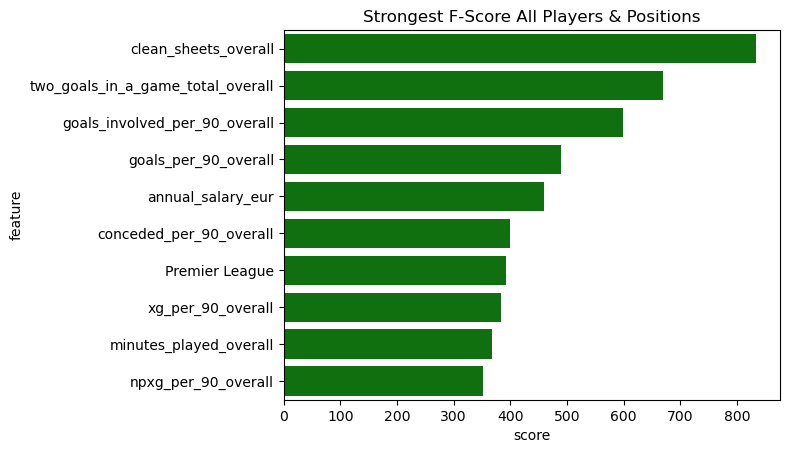

In [46]:
# All players
all_players_fscore = feature_score.sort_values('score', ascending = False).iloc[0:10,0:2]
sns.barplot(data=all_players_fscore, x = 'score', y = 'feature', color='green')
plt.title('Strongest F-Score All Players & Positions')
plt.show()

In baseline models I will consider all features, subsequently to simplify the models there is the opportunity to reduce features. 

I will further analyse which features have the largest impact on market value based on position, then make a decision as to whether to take all variables forward, or a subset of variables, either by position or with all players combined. 

### Baseline Linear Regression Model: All Variables, All Positions

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

Models normally try to find the highest score, e.g. get the best R-squared, with MSE the model needs to know that a higher score is not good and we are trying to get to a lower score. Therefore it uses the neg mean squared error, in order to try to find the highest value. 

In [51]:
# Create baseline linear regression model 
baseline_lin_reg = LinearRegression()
baseline_lin_reg.fit(feature_check_scaled, y_train)

# Make predictions of y
y_predictions = baseline_lin_reg.predict(feature_check_scaled)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_train, y_predictions, squared=False)
r2 = r2_score(y_train, y_predictions)
mae = mean_absolute_error(y_train, y_predictions)
mse = mean_squared_error(y_train, y_predictions)

metrics_dict = {
    'Metric': ['RMSE', 'R2', 'Mean Absolute Error', 'Mean Square Error'],
    'Value': [round(rmse, 2), round(r2, 2), round(mae, 2), round(mse, 2)]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('Metric').T

Metric,RMSE,R2,Mean Absolute Error,Mean Square Error
Value,8914061.08,0.65,5744992.93,7.946048e+13


### Feature Check by Position

Here we assess how the position impacts feature importance. The approach is to: 
   - Utilise the training data and split into each position 
   - Scale features against those within each position rather than across the whole data set, we would expect different distributions by position on different variables
   - Review kbest features vs the target
   - Create baseline models for each position and compare to the baseline model for all positions

In [17]:
# Reset index of Y
y_train_pos_check = y_train.reset_index(drop=True)

# Training table - encoded
train_encoded = pd.concat([X_train_encoded, y_train_pos_check], axis = 1)

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


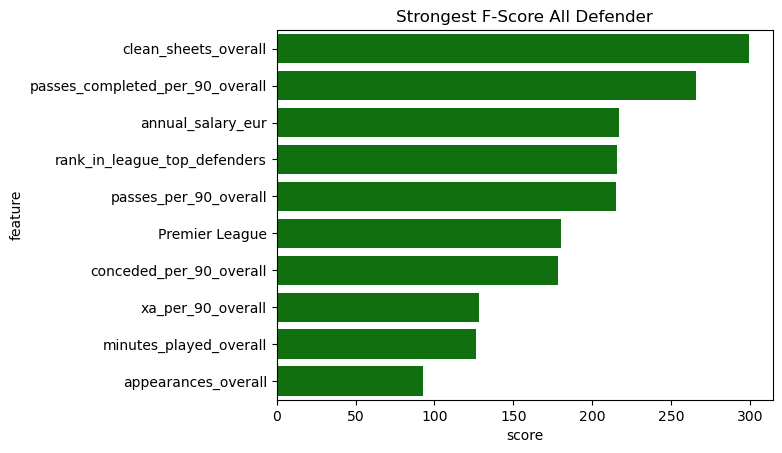

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


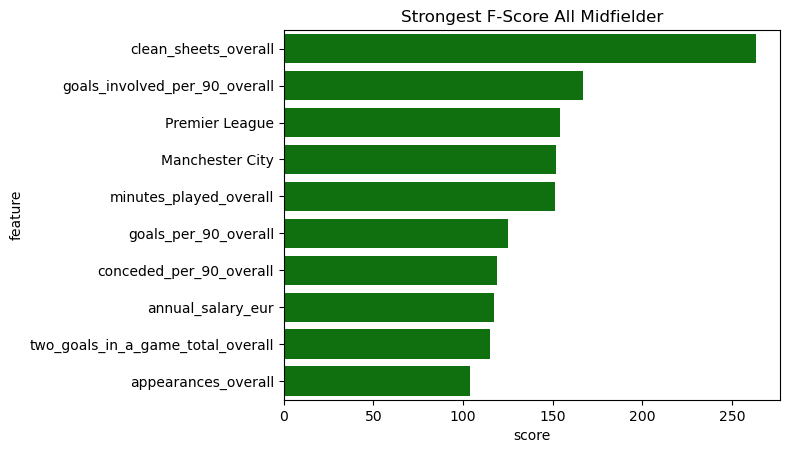

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


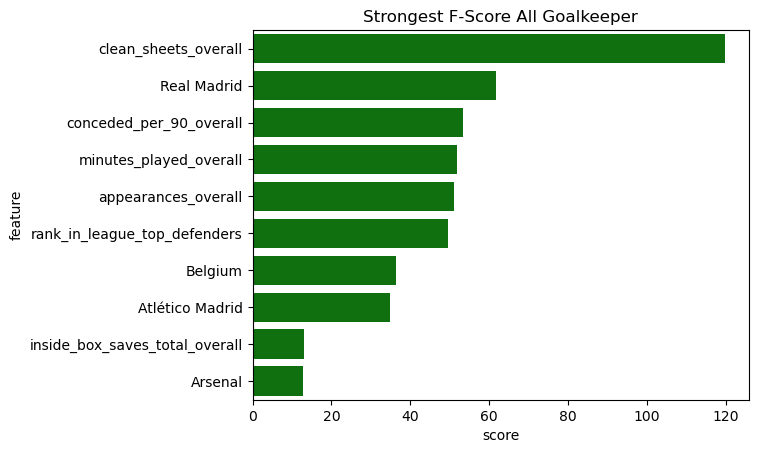

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


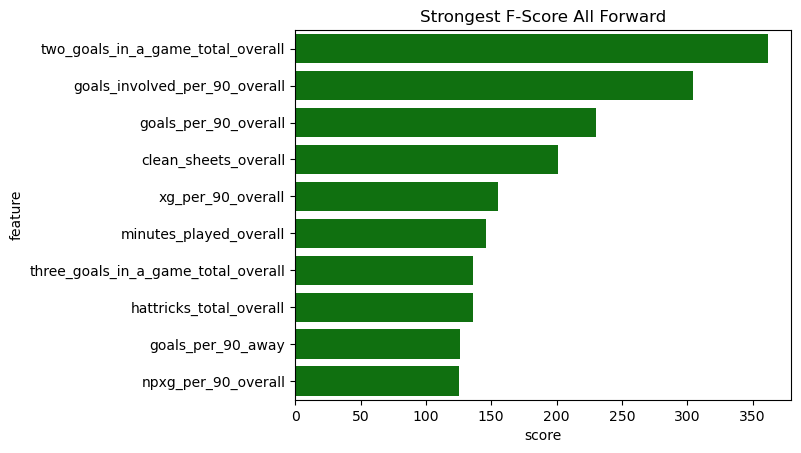

In [50]:
# Feature check of largest variables impact market value
# This is inclusive of all features, including encoded features

for position in player_df_reduced['position'].unique():
    # Filter data for the current position
    position_data = train_encoded[train_encoded[position] == 1]

    # Split X & Y
    X_train_position = position_data.iloc[:, :-1]  
    y_train_position = position_data['market_value_in_eur']

    # Scale the features
    scaler = StandardScaler()
    X_train_position_scaled = scaler.fit_transform(X_train_position)
    X_train_position_scaled_df = pd.DataFrame(data=X_train_position_scaled, columns=X_train_position.columns)

    # Perform feature selection
    my_KBest_position = SelectKBest(score_func=f_regression, k=40)
    my_KBest_position.fit(X_train_position_scaled_df, y_train_position)
    regress_top_position = my_KBest_position.get_support()
    feature_scores = my_KBest_position.scores_

    #Check in dataframe
    feature_score_position = pd.DataFrame({'feature': X_train_position_scaled_df.columns, 
                                           'score': feature_scores, 
                                           'keep': regress_top_position})
    feature_score_position.sort_values('score', ascending = False).iloc[0:15]

    # Plot top features
    positions_fscore = feature_score_position.sort_values('score', ascending = False).iloc[0:10,0:2]
    sns.barplot(data=positions_fscore, x = 'score', y = 'feature', color='green')
    plt.title(f'Strongest F-Score All {position}')
    plt.show()

#### Insights
- Firstly, it is clear that different positions have differing features that drive market value
- We also start to identify how the categorical variables can have a big impact, for example goalkeepers who play for real madrid tend to be expensive, midfielders who play for manchester city tend to be expensive. These have large fscores, and therefore explain a lot of the variance in Market Value
- The decision to include or exclude this information in models is interesting, we want to understand value, therefore high impact features are important, but we also want to understand which statistics have the largest impact too. 
- I have performed the same analysis below to view this difference, only considering the player statistics

### Feature check: only including player statistics

This analysis below is very similar to above, removing the encoded columns to focus only on statistics. 

The purpose is to make a decision on modelling with statistics only, or to include categorical columns

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


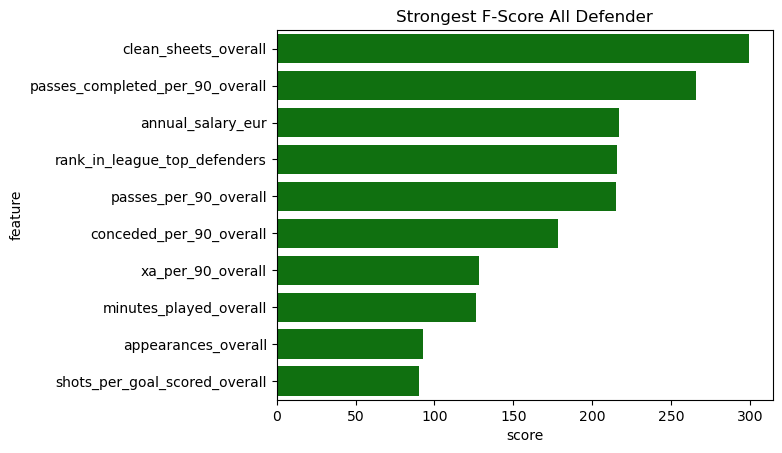

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


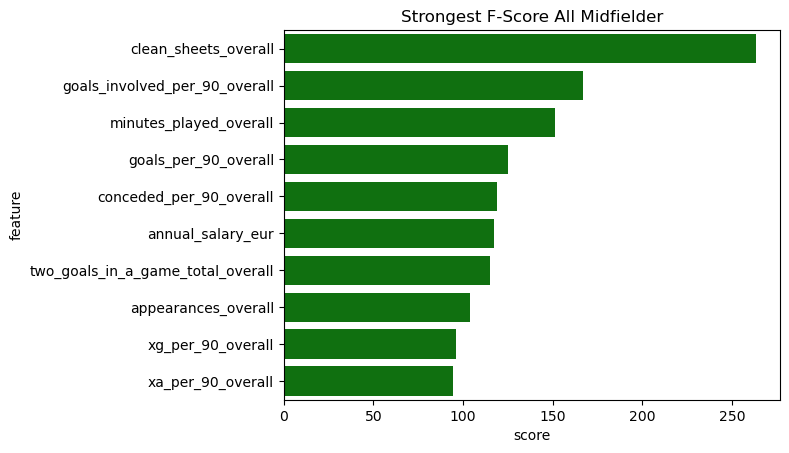

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


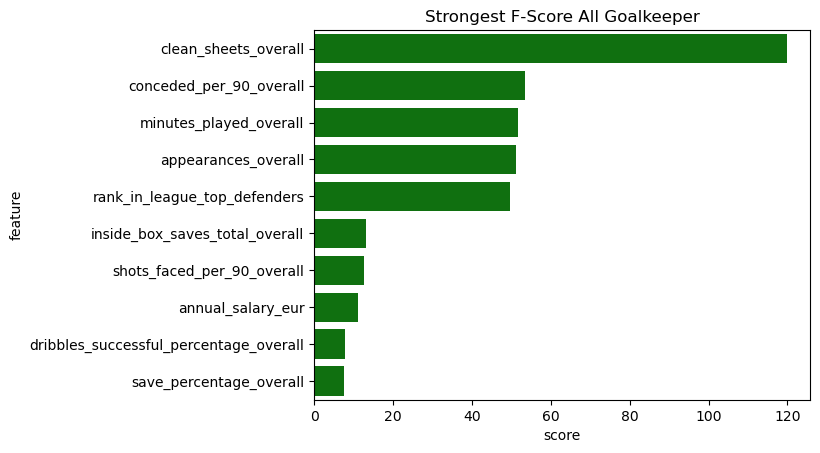

/Users/cristopherhesketh/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms


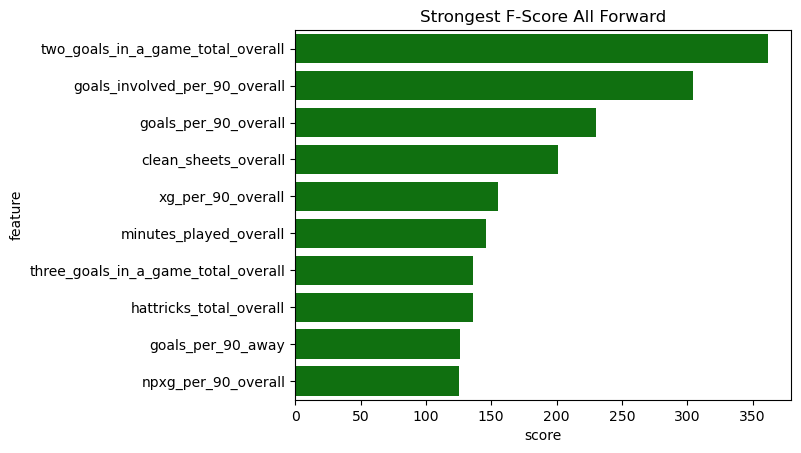

In [47]:
# This analysis removes the categorical features to find a unique list of statistical properties

for position in player_df_reduced['position'].unique():
    # Filter data for the current position
    position_data = train_encoded[train_encoded[position] == 1]

    # Split X & Y
    X_train_position = position_data.iloc[:,:63] 
    y_train_position = position_data['market_value_in_eur']

    # Scale the features
    scaler = StandardScaler()
    X_train_position_scaled = scaler.fit_transform(X_train_position)
    X_train_position_scaled_df = pd.DataFrame(data=X_train_position_scaled, columns=X_train_position.columns)

    # Perform feature selection
    my_KBest_position = SelectKBest(score_func=f_regression, k=40)
    my_KBest_position.fit(X_train_position_scaled_df, y_train_position)
    regress_top_position = my_KBest_position.get_support()
    feature_scores = my_KBest_position.scores_

    #Check in dataframe
    feature_score_position = pd.DataFrame({'feature': X_train_position_scaled_df.columns, 
                                           'score': feature_scores, 
                                           'keep': regress_top_position})
    feature_score_position.sort_values('score', ascending = False).iloc[0:15]

    # Plot top features
    positions_fscore = feature_score_position.sort_values('score', ascending = False).iloc[0:10,0:2]
    sns.barplot(data=positions_fscore, x = 'score', y = 'feature', color='green')
    plt.title(f'Strongest F-Score All {position}')
    plt.show()

#### Insights
- We can start to see very clearly the features that have strong impacts on Market Value by position
- This analysis will be useful for producing position specific models, if those models are identified to be more accurate

### Baseline Regression Model: By Position

Create individual baseline models for each position, scaling individually, and identifying scores. This will help determine whether position specific models are more accurate. 

In [179]:
# Lists of model scores for each position 
position_names = []
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
variance_y = []
SSEs = []

for position in player_df_reduced['position'].unique():
    # Filter data for the current position
    position_data = train_encoded[train_encoded[position] == 1]

    # Split X & Y
    X_train_position = position_data.iloc[:, :-1]  
    y_train_position = position_data['market_value_in_eur']

    # Only include numeric columns for scaling
    X_train_position_numeric = X_train_position.select_dtypes(include=['int', 'float'])

    # Scale the features - individually by position
    scaler = StandardScaler()
    X_train_position_scaled = scaler.fit_transform(X_train_position_numeric)
    X_train_position_scaled_df = pd.DataFrame(data=X_train_position_scaled, columns=X_train_position_numeric.columns)
    
    # Run a baseline linear regression 
    pos_lin_reg = LinearRegression()
    pos_lin_reg.fit(X_train_position_scaled_df, y_train_position)
    y_predictions = pos_lin_reg.predict(X_train_position_scaled_df)
    
    # Calculate performance metrics
    rmse = round(mean_squared_error(y_train_position, y_predictions, squared=False),2)
    r2 = round(r2_score(y_train_position, y_predictions),2)
    mae = round(mean_absolute_error(y_train_position, y_predictions),2)
    mse = round(mean_squared_error(y_train_position, y_predictions),2)
    variance = np.var(y_train_position)
    SSE = (((y_train_position)-y_predictions)**2).sum()
    
    # Append metrics scores for the current position
    position_names.append(position)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    variance_y.append(variance)
    SSEs.append(SSE)

dictionary = {
'Position': position_names,
'RMSE': rmse_scores,
'R2': r2_scores,
'MAE': mae_scores,
'MSE': mse_scores,
'Variance': variance_y,
'Sum Sq Error': SSEs
}

df_position_baseline_scores = pd.DataFrame(dictionary)

df_position_baseline_scores

,Position,RMSE,R2,MAE,MSE,Variance,Sum Sq Error
0,Defender,6490612.76,0.71,4489707.17,4.212805e+13,1.435297e+14,7.085939e+16
1,Midfielder,8918383.60,0.67,6001029.49,7.953757e+13,2.446879e+14,1.259875e+17
2,Goalkeeper,3073238.15,0.91,2265092.79,9.444793e+12,1.017725e+14,3.324567e+15
3,Forward,9230873.01,0.76,6308341.85,8.520902e+13,3.555277e+14,9.892767e+16


#### Insights
##### Baseline Model: All positions
- RMSE = 8914061.08
- R2 = 0.65
- Mean Absolute Error = 5744992.93
- Mean Square Error = 79460484861933.22

##### Baseline Model: Individual Positions

We can see that overall from an R-squared perspective the individual models are more accurate overall and much more accurate in certain positions e.g. goalkeeper and striker (to a lesser extent). However when it comes to Root Mean squared error, the Defenders and Goalkeepers are more accurate, but the Forwards and Midfielders are not. 

Deep diving into the differences:

- There are a few considerations here: 
   - RMSE is the square root of the average squared error of the model (between Y-Actual, and Y-predicted)
   - Forwards and Midfielders are more expensive in general, therefore errors are going to seem larger (they have the largest variance)
    - R-squared effectively the total of the errors squared (Y-Pred vs Y-Actual), dividied by the variance in Y. High variance, would lead to a higher R-squared, as would low errors. 
    - RMSE has a greater focus on accuracy, irrespective of variance in Y. Whereas R-squared takes the variance in Y into consideration, if Y is highly variable, R-squared accounts for this being harder to predict. Due to the variance in forwards pricing it is naturally difficult to predict accurately. 
    

Based on the models not being significantly better I will continue with a single model inclusive of all player positions. There is a case to model goalkeepers separately for more accuracy which could be revisited.

## Transformations

### Target Variable: Market Value

With the huge variance in Y and the log-normal distribution, taking a log of Y to reduce the variance and make the distribution more normal may improve the performance of certain models. 

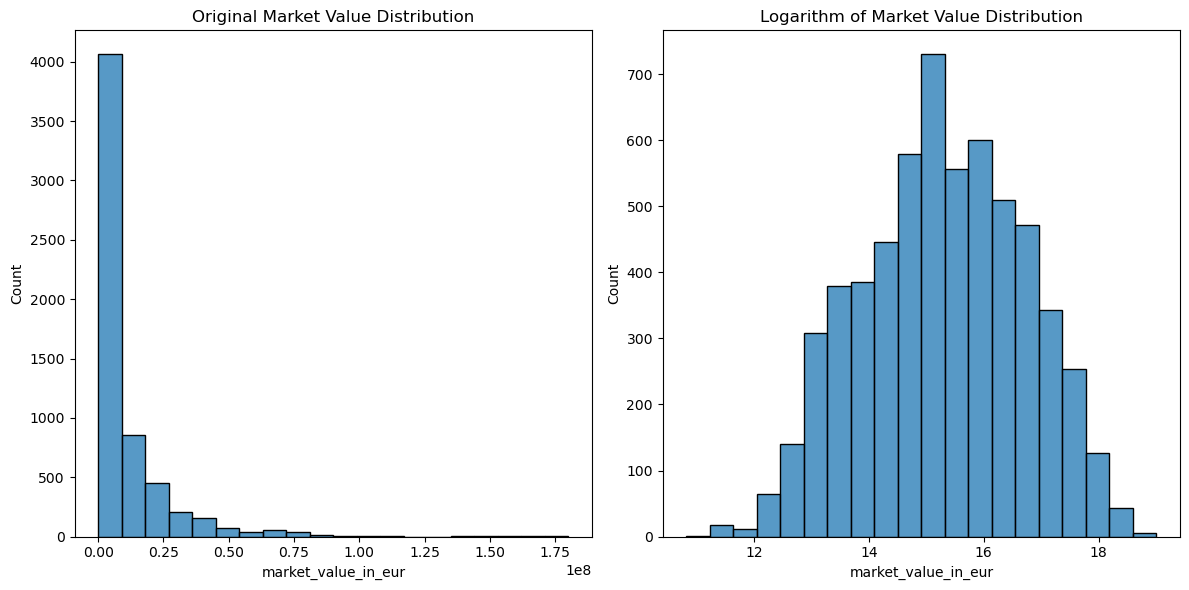

In [167]:
# Transformation of Target Variable
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original market value histogram
sns.histplot(player_df_pre['market_value_in_eur'], bins=20, ax=axs[0])
axs[0].set_title('Original Market Value Distribution')

# Plot logarithm of market value histogram
market_value_log = np.log(player_df_pre['market_value_in_eur'])
sns.histplot(market_value_log, bins=20, ax=axs[1])
axs[1].set_title('Logarithm of Market Value Distribution')

plt.tight_layout()
plt.show()

In [20]:
# Create baseline linear regression model 
y_train_log = np.log(y_train)

baseline_lin_reg = LinearRegression()
baseline_lin_reg.fit(feature_check_scaled, y_train_log)

# Make predictions of y
y_predictions = baseline_lin_reg.predict(feature_check_scaled)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_train_log, y_predictions, squared=False)
r2 = r2_score(y_train_log, y_predictions)
mae = mean_absolute_error(y_train_log, y_predictions)
mse = mean_squared_error(y_train_log, y_predictions)

print(f'RMSE = {round(rmse,2)}')
print(f'R2 = {round(r2,2)}')
print(f'Mean Absolute Error = {round(mae,2)}')
print(f'Mean Square Error = {round(mse,2)}')

RMSE = 0.52
R2 = 0.86
Mean Absolute Error = 0.39
Mean Square Error = 0.27


In [202]:
# Lists of model scores for each position 
position_names = []
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
variance_y = []
SSEs = []

for position in player_df_reduced['position'].unique():
    # Filter data for the current position
    position_data = train_encoded[train_encoded[position] == 1]

    # Split X & Y
    X_train_position = position_data.iloc[:, :-1]  
    y_train_position = np.log(position_data['market_value_in_eur'])

    # Scale the features - individually by position
    scaler = StandardScaler()
    X_train_position_scaled = scaler.fit_transform(X_train_position)
    X_train_position_scaled_df = pd.DataFrame(data=X_train_position_scaled, columns=X_train_position.columns)
    
    # Run a baseline linear regression 
    pos_lin_reg = LinearRegression()
    pos_lin_reg.fit(X_train_position_scaled_df, y_train_position)
    y_predictions = pos_lin_reg.predict(X_train_position_scaled_df)
    
    # Calculate performance metrics
    rmse = round(mean_squared_error(y_train_position, y_predictions, squared=False),2)
    r2 = round(r2_score(y_train_position, y_predictions),2)
    mae = round(mean_absolute_error(y_train_position, y_predictions),2)
    mse = round(mean_squared_error(y_train_position, y_predictions),2)
    variance = np.var(y_train_position)
    SSE = (((y_train_position)-y_predictions)**2).sum()
    
    # Append metrics scores for the current position
    position_names.append(position)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    variance_y.append(variance)
    SSEs.append(SSE)

dictionary = {
'Position': position_names,
'RMSE': rmse_scores,
'R2': r2_scores,
'MAE': mae_scores,
'MSE': mse_scores,
'Variance': variance_y,
'Sum Sq Error': SSEs
}

df_position_baseline_scores = pd.DataFrame(dictionary)

df_position_baseline_scores

,Position,RMSE,R2,MAE,MSE,Variance,Sum Sq Error
0,Defender,0.48,0.88,0.36,0.23,1.895922,391.766004
1,Midfielder,0.49,0.87,0.36,0.24,1.894695,384.067110
2,Goalkeeper,0.34,0.94,0.27,0.12,1.920545,40.896452
3,Forward,0.40,0.92,0.31,0.16,2.084194,188.104017


### Insights
This provides much cleaner and more easily interpretable model scores, interestingly the positional models now outperform the all players model on both R-squared and RMSE. We have many 'extreme' values in the target due to some players with extremely high valuations, reducing these logarithimically gives the outliers less 'weight' in the scoring. 


## Conclusion 
- The 5 most predictive features utilising k-best are: 


    - Clean Sheets Overall: This is expected and is a factor of playing for a good team, better teams concede less goals. 
    - Two Goals in a game overall: Based on previous EDA we identified Forwards tend to be the most expensive, scoring two goals per game, is an extension of this, driving the value of all players. If you score more goals, you tend to be more expensive: 
    - Goals Involved per 90 Overall: The more goal involvements the higher the value (as expected)
    - Goals per 90 overall: The more goals the higher the value (as expected)
    - Annual Salary in Euros: Salary is typically related to performance and skills, this would drive value. 

- For the purpose of the first set of models I will continue to use all variables, subsequently I will use k-best within the pipeline to reduce the number of variables based on model performance.  

- We identified that for different positions, there are different statistics that are most predictive in terms of calculating value. This is expected and a decision is required on whether to build position specific models or not. Baseline models will continue for all positions, with a potential next step of building individual models per position. 

- We produced a baseline linear regression model, with a RMSE of ~9 Million, and R-squared of 0.65. 

- We also producded individual positional based linear regression models which do not massively improve the model performance. 

- Finally, we took a log of the Y variable and ran that through linear regression models for all players, and for each position. The performance of these models was significantly higher, interestingly, the positional models outperformed the all player model when considering the log of Y as the target. 


#### Next Steps
1. Build baseline regression models considering all players and identify the best model
2. Utilise the best models from this with a target of Log-Y
3. Consider position specific modelling - A decision will be made based on time